In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

for gpu in tf.config.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)
keras = tf.keras

In [2]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

def trend(time, slope=0):
    return slope * time


def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))


def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)


def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level


def window_dataset(series, window_size, batch_size=32,
                   shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

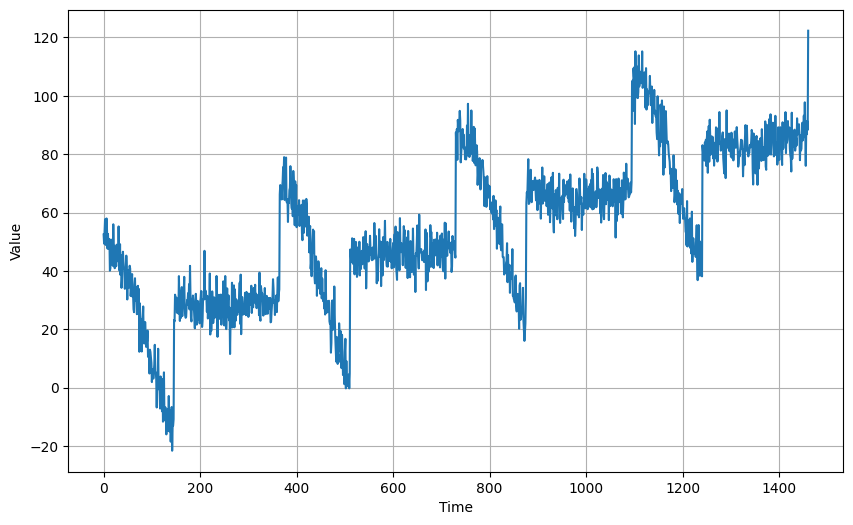

In [3]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [4]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [5]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size, batch_size=128)

model = keras.models.Sequential([
    keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                        input_shape=[None]),
    keras.layers.SimpleRNN(100, return_sequences=True),
    keras.layers.SimpleRNN(100),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x: x * 200.0)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 20))
optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100


C:\Users\sebas\anaconda3\envs\tensorflow_1\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 3s 146ms/step - loss: 41.2256 - mae: 41.7234 - lr: 1.0000e-07
Epoch 2/100
8/8 [==============================] - 1s 64ms/step - loss: 29.8993 - mae: 30.3956 - lr: 1.1220e-07
Epoch 3/100
8/8 [==============================] - 1s 56ms/step - loss: 25.7270 - mae: 26.2212 - lr: 1.2589e-07
Epoch 4/100
8/8 [==============================] - 1s 59ms/step - loss: 24.2067 - mae: 24.6980 - lr: 1.4125e-07
Epoch 5/100
8/8 [==============================] - 1s 63ms/step - loss: 22.2807 - mae: 22.7740 - lr: 1.5849e-07
Epoch 6/100
8/8 [==============================] - 1s 68ms/step - loss: 20.8722 - mae: 21.3651 - lr: 1.7783e-07
Epoch 7/100
8/8 [==============================] - 1s 67ms/step - loss: 19.9517 - mae: 20.4471 - lr: 1.9953e-07
Epoch 8/100
8/8 [==============================] - 1s 66ms/step - loss: 18.9619 - mae: 19.4555 - lr: 2.2387e-07
Epoch 9/100
8/8 [==============================] - 1s 77ms/step - loss: 17.5702 - mae: 18.0597 - lr: 2.5119e-07
Epo

(1e-07, 0.0001, 0.0, 30.0)

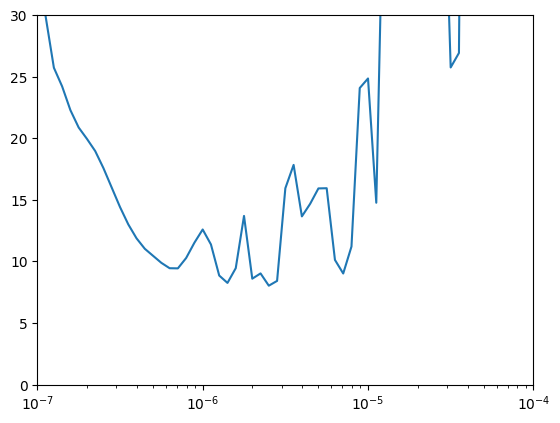

In [6]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-7, 1e-4, 0, 30])

In [7]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size, batch_size=128)
valid_set = window_dataset(x_valid, window_size, batch_size=128)

model = keras.models.Sequential([
    keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                        input_shape=[None]),
    keras.layers.SimpleRNN(100, return_sequences=True),
    keras.layers.SimpleRNN(100),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x: x * 200.0)
])
optimizer = keras.optimizers.SGD(lr=1.5e-6, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=50)
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint", save_best_only=True)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint])

Epoch 1/500
      8/Unknown - 2s 79ms/step - loss: 106.7742 - mae: 107.2740INFO:tensorflow:Assets written to: my_checkpoint\assets
8/8 [==============================] - 4s 413ms/step - loss: 106.7742 - mae: 107.2740 - val_loss: 86.5499 - val_mae: 87.0499
Epoch 2/500
8/8 [==============================] - 3s 358ms/step - loss: 63.2364 - mae: 63.7350 - val_loss: 70.0095 - val_mae: 70.5095
Epoch 3/500
8/8 [==============================] - 3s 374ms/step - loss: 31.1209 - mae: 31.6178 - val_loss: 48.6686 - val_mae: 49.1686
Epoch 4/500
8/8 [==============================] - 2s 337ms/step - loss: 23.8031 - mae: 24.2984 - val_loss: 23.4631 - val_mae: 23.9625
Epoch 5/500
8/8 [==============================] - 3s 402ms/step - loss: 17.7782 - mae: 18.2730 - val_loss: 17.6211 - val_mae: 18.1199
Epoch 6/500
8/8 [==============================] - 3s 383ms/step - loss: 12.6282 - mae: 13.1186 - val_loss: 13.3757 - val_mae: 13.8697
Epoch 7/500
8/8 [==============================] - 3s 370ms/step - lo

In [8]:
model = keras.models.load_model("my_checkpoint")

In [9]:
rnn_forecast = model_forecast(
    model,
    series[split_time - window_size:-1],
    window_size)[:, 0]

15/15 [==============================] - 0s 18ms/step


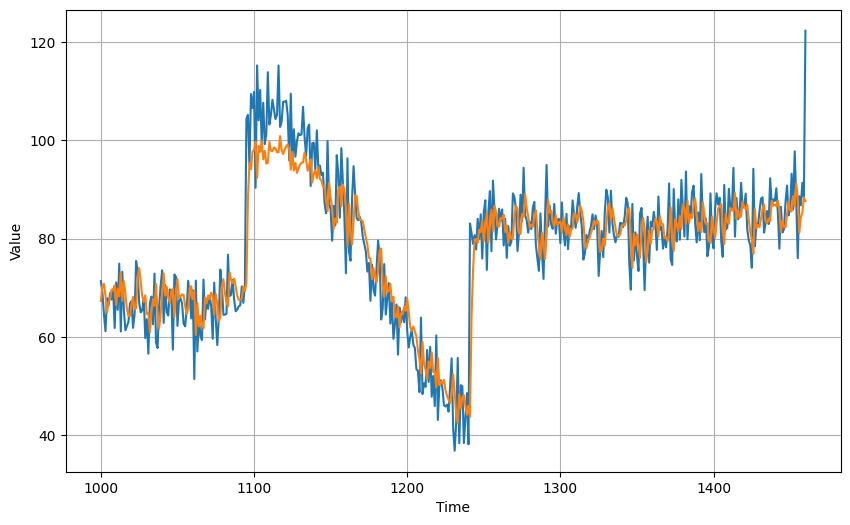

In [10]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [11]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

5.24202

In [12]:
#sequence to sequence

In [13]:
def seq2seq_window_dataset(series, window_size, batch_size=32,
                           shuffle_buffer=1000):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [14]:
for X_batch, Y_batch in seq2seq_window_dataset(tf.range(10), 3,
                                               batch_size=1):
    print("X:", X_batch.numpy())
    print("Y:", Y_batch.numpy())

X: [[[4]
  [5]
  [6]]]
Y: [[[5]
  [6]
  [7]]]
X: [[[1]
  [2]
  [3]]]
Y: [[[2]
  [3]
  [4]]]
X: [[[0]
  [1]
  [2]]]
Y: [[[1]
  [2]
  [3]]]
X: [[[5]
  [6]
  [7]]]
Y: [[[6]
  [7]
  [8]]]
X: [[[2]
  [3]
  [4]]]
Y: [[[3]
  [4]
  [5]]]
X: [[[6]
  [7]
  [8]]]
Y: [[[7]
  [8]
  [9]]]
X: [[[3]
  [4]
  [5]]]
Y: [[[4]
  [5]
  [6]]]


In [15]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(100, return_sequences=True,
                           input_shape=[None, 1]),
    keras.layers.SimpleRNN(100, return_sequences=True),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x: x * 200)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 30))
optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100


C:\Users\sebas\anaconda3\envs\tensorflow_1\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 2s 67ms/step - loss: 273.4389 - mae: 273.9389 - lr: 1.0000e-07
Epoch 2/100
8/8 [==============================] - 1s 64ms/step - loss: 234.4556 - mae: 234.9556 - lr: 1.0798e-07
Epoch 3/100
8/8 [==============================] - 1s 65ms/step - loss: 176.0457 - mae: 176.5456 - lr: 1.1659e-07
Epoch 4/100
8/8 [==============================] - 1s 68ms/step - loss: 108.0330 - mae: 108.5329 - lr: 1.2589e-07
Epoch 5/100
8/8 [==============================] - 1s 67ms/step - loss: 45.6624 - mae: 46.1597 - lr: 1.3594e-07
Epoch 6/100
8/8 [==============================] - 1s 66ms/step - loss: 45.1471 - mae: 45.6449 - lr: 1.4678e-07
Epoch 7/100
8/8 [==============================] - 1s 64ms/step - loss: 40.0578 - mae: 40.5547 - lr: 1.5849e-07
Epoch 8/100
8/8 [==============================] - 1s 63ms/step - loss: 33.2519 - mae: 33.7477 - lr: 1.7113e-07
Epoch 9/100
8/8 [==============================] - 1s 63ms/step - loss: 31.4473 - mae: 31.9426 - lr: 1.8478e

(1e-07, 0.0001, 0.0, 30.0)

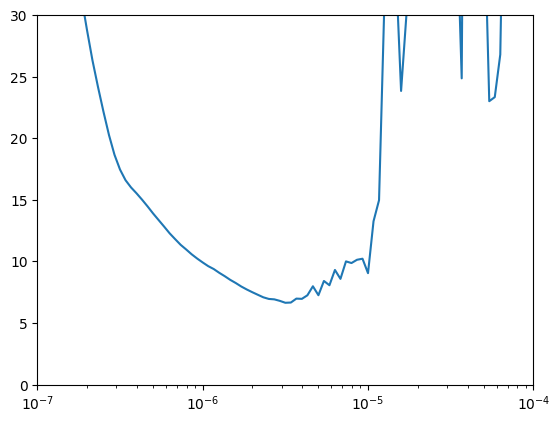

In [16]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-7, 1e-4, 0, 30])

In [17]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=128)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(100, return_sequences=True,
                           input_shape=[None, 1]),
    keras.layers.SimpleRNN(100, return_sequences=True),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x: x * 200.0)
])
optimizer = keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping])

Epoch 1/500
8/8 [==============================] - 2s 125ms/step - loss: 100.8509 - mae: 101.3496 - val_loss: 50.8644 - val_mae: 51.3643
Epoch 2/500
8/8 [==============================] - 1s 75ms/step - loss: 53.3613 - mae: 53.8594 - val_loss: 68.2553 - val_mae: 68.7552
Epoch 3/500
8/8 [==============================] - 1s 82ms/step - loss: 33.3219 - mae: 33.8201 - val_loss: 12.1298 - val_mae: 12.6191
Epoch 4/500
8/8 [==============================] - 1s 77ms/step - loss: 21.8048 - mae: 22.3003 - val_loss: 23.3953 - val_mae: 23.8916
Epoch 5/500
8/8 [==============================] - 1s 77ms/step - loss: 16.0248 - mae: 16.5181 - val_loss: 30.3992 - val_mae: 30.8981
Epoch 6/500
8/8 [==============================] - 1s 78ms/step - loss: 13.2512 - mae: 13.7415 - val_loss: 24.4678 - val_mae: 24.9670
Epoch 7/500
8/8 [==============================] - 1s 83ms/step - loss: 11.4983 - mae: 11.9865 - val_loss: 17.7587 - val_mae: 18.2528
Epoch 8/500
8/8 [==============================] - 1s 70ms/

In [18]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

45/45 [==============================] - 1s 15ms/step


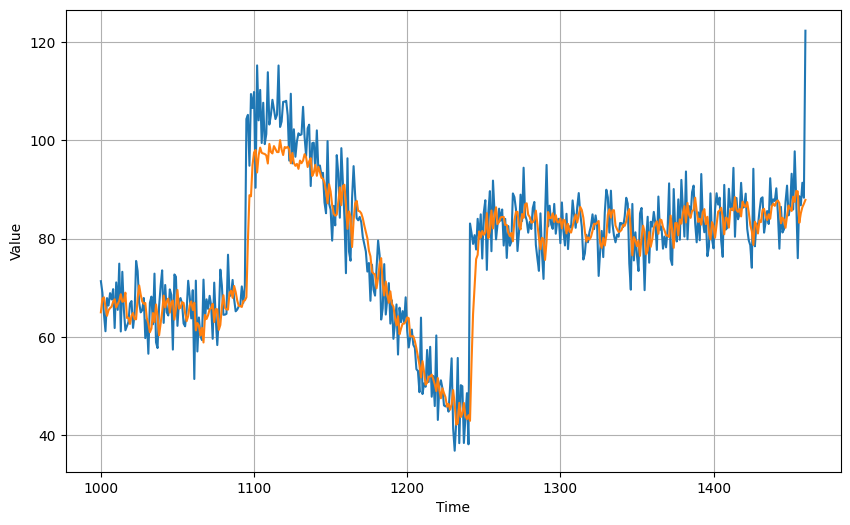

In [19]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [20]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

5.1419373